## **Fashion MNIST Classification using a Convolutional Neural Network (CNN)**

This Jupyter Notebook is dedicated to exploring the Fashion MNIST dataset through the implementation of a Convolutional Neural Network (CNN). Fashion MNIST is a dataset consisting of 70,000 grayscale images of 10 fashion categories.

# Overview of the Notebook

**Data Preparation:** The data is loaded directly from the dataset's source and reshaped appropriately for the CNN model. The dataset is then split into training, validation, and testing sets to prepare for the model training and evaluation phases.

**Data Visualization:** A series of images from the dataset are displayed to provide insight into the type of items that need classification. This helps in understanding the challenges in distinguishing between different fashion items.

**MLP:** A Multi-Layer Perceptron is trained on the data to show the limits of this approach and to provide a benchmark for the CNN based model.

**Model Architecture:** The CNN architecture is defined, detailing the layers used, activation functions, and other parameters critical to learning image features effectively.

**Model Training:** The CNN is trained on the training dataset, utilizing techniques such as minibatch gradient descent and regularization to optimize performance and reduce overfitting.

**Model Evaluation:** After training, the model is evaluated on the validation and test datasets. Metrics such as accuracy, precision, recall, F1-score, and a confusion matrix are used to assess performance.

**Result Visualization:** Results are visualized through various plots, including training-validation accuracy and loss over epochs, to provide a clear view of the model's learning process and final performance.

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


This section of code is dedicated to loading the FashionMNIST dataset which contains grayscale images of various clothing items. We apply a minimal transformation to convert these images into PyTorch tensors, making them suitable for model processing. This transformation is essential for any subsequent operations such as training or visualizing the images. After loading the dataset, we also print out the sizes of the training and testing datasets to verify that they have been loaded correctly and to understand the scope of data we're working with.

In [ ]:
# Minimal transform just for initial loading
transform = transforms.Compose([
    transforms.ToTensor()  # This is required for visualizing images initially
])

# Loading FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Print the size of the dataset
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]

Training dataset size: 60000
Test dataset size: 10000


In this section, we visualize a sample of images from the FashionMNIST dataset to get a sense of the types of clothing items included. We start by loading a small batch of images and display them using matplotlib. The function imshow is specifically tailored to handle and display these grayscale images appropriately. Additionally, we enumerate the class labels associated with these images to clarify what each represents.

Following the image display, we analyze the distribution of different clothing item classes within the entire training dataset. This helps us understand the variety and balance of data we're working with. A bar graph is generated to visualize the frequency of each class, providing a clear overview of the dataset composition.

Sample images:


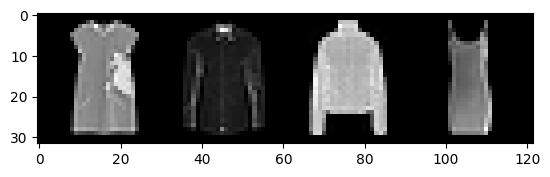

Labels: Dress        Shirt        Coat         Dress       


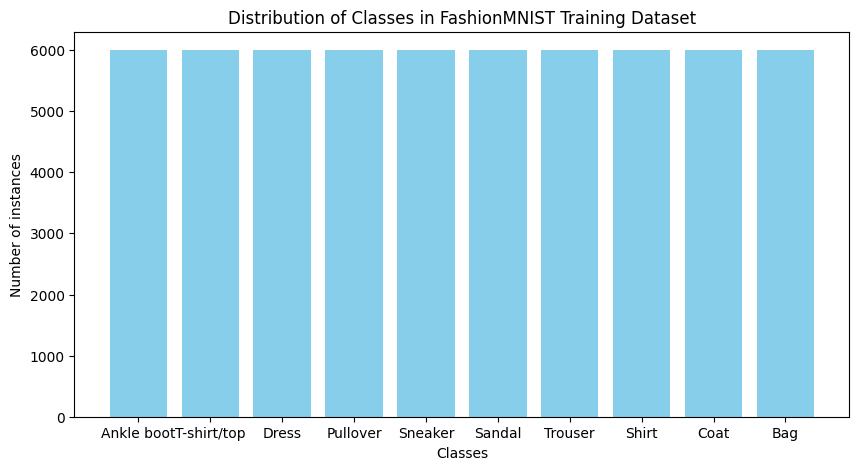

In [ ]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Function to show images
def imshow(img):
    npimg = img.numpy()
    # Since FashionMNIST images are grayscale, we use 'gray' colormap
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    plt.show()

# Get some random training images
dataiter = iter(DataLoader(train_dataset, batch_size=4, shuffle=True))
images, labels = next(dataiter)

# Show images
print('Sample images:')
imshow(torchvision.utils.make_grid(images))

# Labels for FashionMNIST classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# Print corresponding labels
print('Labels:', ' '.join(f'{classes[labels[j]]:12s}' for j in range(4)))

# Plot the distribution of classes in the training dataset
class_counts = {}
for _, label in train_dataset:
    label = classes[label]
    if label in class_counts:
        class_counts[label] += 1
    else:
        class_counts[label] = 1

# Visualization of the class distribution
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of instances')
plt.title('Distribution of Classes in FashionMNIST Training Dataset')
plt.show()

In this segment, we set up the data transformations necessary for processing the FashionMNIST dataset during training and testing phases. The transformations include normalizing the grayscale images and applying data augmentation techniques such as random flips and rotations to enhance the model's generalization capabilities. These augmentations are applied only to the training data to simulate a variety of clothing appearances and positions, which helps in reducing overfitting and improving model robustness.

We also split the original training dataset into a new training set and a validation set. This split allows us to evaluate the model on a separate portion of the data that it hasn't trained on, providing us with feedback on how well the model might perform on unseen data. Each subset of the data—training, validation, and test—is then assigned the appropriate transformations.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations for training and testing
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjusted for single channel grayscale images
])

train_transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjusted for single channel grayscale images
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjusted for single channel grayscale images
])

# Assuming train_dataset and test_dataset are already defined with FashionMNIST
# Split the training dataset into training and validation sets
validation_split = 0.2
train_size = int((1 - validation_split) * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_data, validation_data = random_split(train_dataset, [train_size, validation_size])

# Apply appropriate transformations to each dataset
train_data.dataset.transform = train_transform  # Non-augmented training data
# train_data.dataset.transform = train_transform_augment  # Augmented training data
validation_data.dataset.transform = test_transform  # Non-augmented for validation

# Display sizes of each dataset
print(f"Training Data: {len(train_data)} samples")
print(f"Validation Data: {len(validation_data)} samples")
print(f"Test Data: {len(test_dataset)} samples")

Training Data: 48000 samples
Validation Data: 12000 samples
Test Data: 10000 samples


This section demonstrates the impact of various data augmentation techniques on a single image from the FashionMNIST dataset. Data augmentation is a critical technique in deep learning used to increase the diversity of data available for training models, without actually collecting new data. This is achieved by applying random transformations such as flipping, rotation, and affine transformations to the training images.

The function visualize_single_image_augmentations is designed to apply a series of transformations to a single image and display the results side by side. This visualization helps in understanding how each augmentation can potentially alter the data and thus how it might affect the learning process of the neural network.

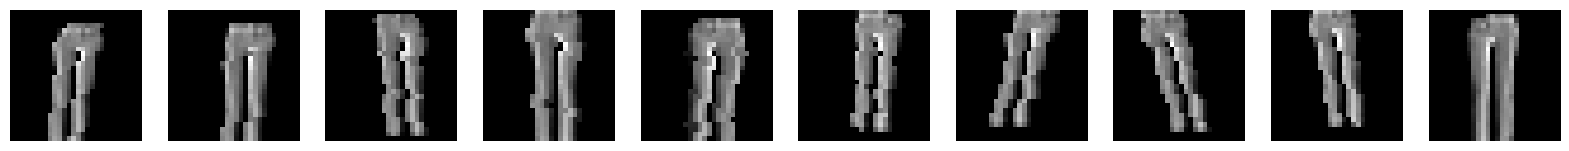

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms

def visualize_single_image_augmentations(image, transform, repetitions=10):
    fig, axes = plt.subplots(1, repetitions, figsize=(20, 2))
    for i in range(repetitions):
        # Apply the augmentation transform each time
        img = transform(image)
        # Convert tensor to numpy for plotting
        img = img.numpy().squeeze()  # Remove channel dim because it's grayscale
        # Normalize for display
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to 0-1
        axes[i].imshow(img, cmap='gray')  # Use grayscale colormap
        axes[i].axis('off')
    plt.show()

# Load a single image from FashionMNIST without any transformation applied
original_image, _ = datasets.FashionMNIST(root='./data', train=True, download=True, transform=None)[432]

# Define augmentation transform suitable for grayscale images
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust normalization for one channel
])

# Visualize the same image with different augmentations applied
visualize_single_image_augmentations(original_image, augmentation_transform)

In this section, we implement crucial functionality to efficiently train neural networks while avoiding overfitting through the use of an early stopping mechanism. Early stopping is a form of regularization used to halt the training process when the model's performance on the validation set stops improving after a specified number of epochs. This approach not only helps in preventing overfitting but also reduces computational waste by stopping training once further training ceases to provide benefits.

**EarlyStopping Class:** This class monitors the validation loss during the training process. If the validation loss does not improve beyond a small delta for a specified 'patience' number of epochs, it triggers the stopping of the training process. Additionally, it handles the saving of the best model state to ensure we retain the model at its peak performance.

**train_model Function:** This function orchestrates the model training process, utilizing the EarlyStopping class. It conducts training over a specified number of epochs or until early stopping is triggered, whichever comes first. The function takes care of running both training and validation phases within each epoch, updating weights, and calculating losses. It is designed to be flexible enough to handle different models, optimizers, and loss functions.

**train_cnn_model Function:** Similar to train_model, this function is adapted specifically to handle models that return multiple outputs, such as our CNN model that returns both the final classification output and intermediate feature maps. It ensures that only the logits are used for loss calculation and backpropagation.

In [ ]:
#EARLY STOPPING AND TRAINING FUCNTIONS

class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses

def train_cnn_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Get only the logits from the model's output which is the first element of the tuple
            output, _ = model(data)  # Adjust here to unpack the tuple and ignore the second output
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                # Again, get only the logits when evaluating
                output, _ = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses


In this section, we define a Multilayer Perceptron (MLP) model suitable for classifying images from the FashionMNIST dataset. The MLP is a basic type of neural network that consists of several fully connected layers. It's particularly effective for tasks involving fixed-size inputs and where the spatial relationship between pixels is less critical.

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28*28, 512),  # Adjusted input layer to match 28x28 input size
            nn.ReLU(),
            nn.Dropout(0.5),  # Adding dropout for regularization
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),  # Another dropout layer
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),  # Output layer for 10 classes
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

# Instantiate the model and move it to the available device
model = MLP().to(device)
summary(model, input_size=(1, 28, 28))  # Updated to single channel, 28x28 input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
           Dropout-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.16
Estimated T

This code snippet establishes the training environment for our Multilayer Perceptron model, configuring essential parameters and preparing DataLoader objects for handling training, validation, and testing datasets. Key training parameters such as batch size, learning rate, and regularization are defined. The model is then trained using these parameters, with early stopping implemented to prevent overfitting by halting training if validation loss does not improve for a specified number of epochs. Finally, the training and validation losses are plotted to visualize the learning progress over the epochs, providing insight into the model's performance and convergence behavior.

Epoch: 1, Training Loss: 1.5057, Validation Loss: 0.7677
Validation loss decreased (0.767739 --> 0.767739).  Saving model ...
Epoch: 2, Training Loss: 0.7416, Validation Loss: 0.6105
Validation loss decreased (0.767739 --> 0.610470).  Saving model ...
Epoch: 3, Training Loss: 0.6279, Validation Loss: 0.5416
Validation loss decreased (0.610470 --> 0.541552).  Saving model ...
Epoch: 4, Training Loss: 0.5691, Validation Loss: 0.4977
Validation loss decreased (0.541552 --> 0.497723).  Saving model ...
Epoch: 5, Training Loss: 0.5311, Validation Loss: 0.4710
Validation loss decreased (0.497723 --> 0.471015).  Saving model ...
Epoch: 6, Training Loss: 0.5025, Validation Loss: 0.4486
Validation loss decreased (0.471015 --> 0.448649).  Saving model ...
Epoch: 7, Training Loss: 0.4769, Validation Loss: 0.4359
Validation loss decreased (0.448649 --> 0.435931).  Saving model ...
Epoch: 8, Training Loss: 0.4626, Validation Loss: 0.4188
Validation loss decreased (0.435931 --> 0.418817).  Saving mo

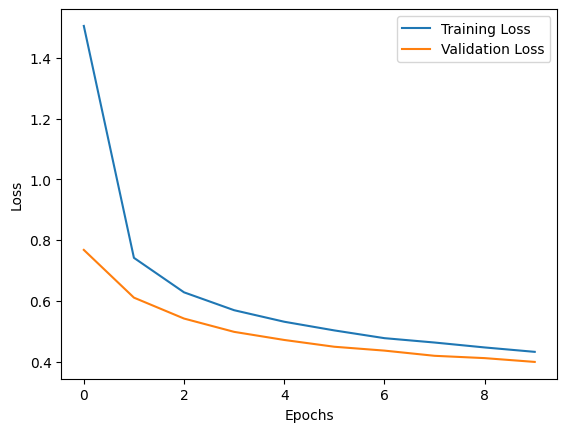

In [ ]:

batch_size = 512
epochs = 10
patience = 5
lr = 0.0001
reg = 0.0001

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# MLP model, criterion, optimizer, and early stopping initialization
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)  # L2 regularization
early_stopper = EarlyStopping(patience=patience)

# Training the model
train_losses, val_losses = train_model(epochs, model, optimizer, criterion, train_loader, validation_loader, early_stopper)

# Plotting the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This code block outlines the architecture of our Convolutional Neural Network (CNN), which is tailored for image classification tasks like those presented by the FashionMNIST dataset. The network comprises several convolutional layers that are designed to extract spatial hierarchies of features through filters. These layers are interspersed with ReLU activations and max pooling for non-linearity and dimensionality reduction, respectively. Dropout layers are incorporated to mitigate overfitting. The classifier section flattens the feature maps and passes them through dense layers to output predictions for the ten classes. Both the prediction and the result of the last convolutional layer are returned as output. A summary generated by torchsummary provides a detailed breakdown of the model's layers, parameters, and the shape transformations that occur throughout the network.

In [ ]:
from torch import nn
from torchsummary import summary

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # Input: (1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            # Output: (32, 28, 28)
            # 32 filters, each of shape (1, 3, 3)

            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            # Output: (32, 28, 28)
            # 32 filters, each of shape (32, 3, 3)

            nn.ReLU(),

            nn.MaxPool2d(2, 2),
            # Output: (32, 14, 14) — halves height and width

            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            # Output: (64, 14, 14)
            # 64 filters, each of shape (32, 3, 3)

            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            # Output: (64, 14, 14)
            # 64 filters, each of shape (64, 3, 3)

            nn.ReLU(),

            nn.MaxPool2d(2, 2),
            # Output: (64, 7, 7)

            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Output: (64 * 7 * 7) = (3136,)

            nn.Linear(64 * 7 * 7, 64),
            # Output: (64,)
            # Fully connected layer with weight matrix shape (64, 3136)

            nn.ReLU(),

            nn.Dropout(0.5),

            nn.Linear(64, 10)
            # Output: (10,) — 10 classes for MNIST digits. Linear activation as the nn.CrossEntropyLoss() already contains a softmax within itself
        )

    def forward(self, x):
        x = self.features(x)
        last_conv_output = x
        x = self.classifier(x)
        return x, last_conv_output

# Instantiate and summarize the model
cnn_model = CNN().to(device)
summary(cnn_model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
           Dropout-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]          18,496
              ReLU-8           [-1, 64, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          36,928
             ReLU-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
          Dropout-12             [-1, 64, 7, 7]               0
          Flatten-13                 [-1, 3136]               0
           Linear-14                   

This section initializes and trains the CNN model for the FashionMNIST dataset. We set up DataLoaders to handle the batches of training, validation, and testing data, and specify training parameters such as batch size, learning rate, and regularization strength. The CNN model is equipped with an early stopping mechanism to enhance training efficiency by halting the process if the validation loss does not improve for a given number of consecutive epochs. After training, we visualize the training and validation loss curves to assess the model’s learning progression and stability across the specified epochs. This visualization helps in understanding the effectiveness of the training process and in making any necessary adjustments for optimization.

Epoch: 1, Training Loss: 1.0059, Validation Loss: 0.4897
Validation loss decreased (0.489709 --> 0.489709).  Saving model ...
Epoch: 2, Training Loss: 0.5890, Validation Loss: 0.4166
Validation loss decreased (0.489709 --> 0.416612).  Saving model ...
Epoch: 3, Training Loss: 0.5277, Validation Loss: 0.3911
Validation loss decreased (0.416612 --> 0.391122).  Saving model ...
Epoch: 4, Training Loss: 0.4813, Validation Loss: 0.3593
Validation loss decreased (0.391122 --> 0.359287).  Saving model ...
Epoch: 5, Training Loss: 0.4534, Validation Loss: 0.3348
Validation loss decreased (0.359287 --> 0.334754).  Saving model ...
Epoch: 6, Training Loss: 0.4262, Validation Loss: 0.3114
Validation loss decreased (0.334754 --> 0.311370).  Saving model ...
Epoch: 7, Training Loss: 0.4075, Validation Loss: 0.2935
Validation loss decreased (0.311370 --> 0.293486).  Saving model ...
Epoch: 8, Training Loss: 0.3918, Validation Loss: 0.2834
Validation loss decreased (0.293486 --> 0.283435).  Saving mo

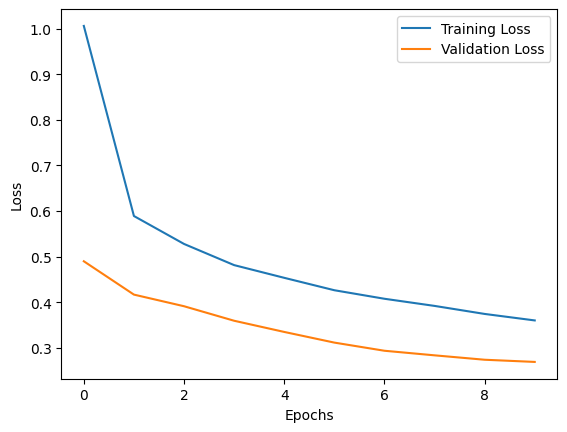

In [ ]:
batch_size = 512
epochs = 10
patience = 5
lr = 0.001
reg = 0.0001

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#CNN model, criterion, optimizer, and early stopping initialization
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=reg)  # Ensure this is for the cnn_model
early_stopper = EarlyStopping(patience=patience)

# Training the model
train_losses, val_losses = train_cnn_model(epochs, cnn_model, cnn_optimizer, criterion, train_loader, validation_loader, early_stopper)

# Plotting the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This code segment is designed to demonstrate the internal workings of the CNN by visualizing the feature maps generated from its convolutional layers. We execute this for multiple images to compare how different inputs activate the network's filters. The function visualize_features_and_inputs displays the original input images alongside their corresponding feature maps, allowing for a visual assessment of what features the model is focusing on for each input. This visualization is crucial for understanding model behavior and ensures that the CNN is learning meaningful patterns from the FashionMNIST dataset. Each row in the resulting plot corresponds to one input image and its selected feature maps, providing a comprehensive view across multiple examples.

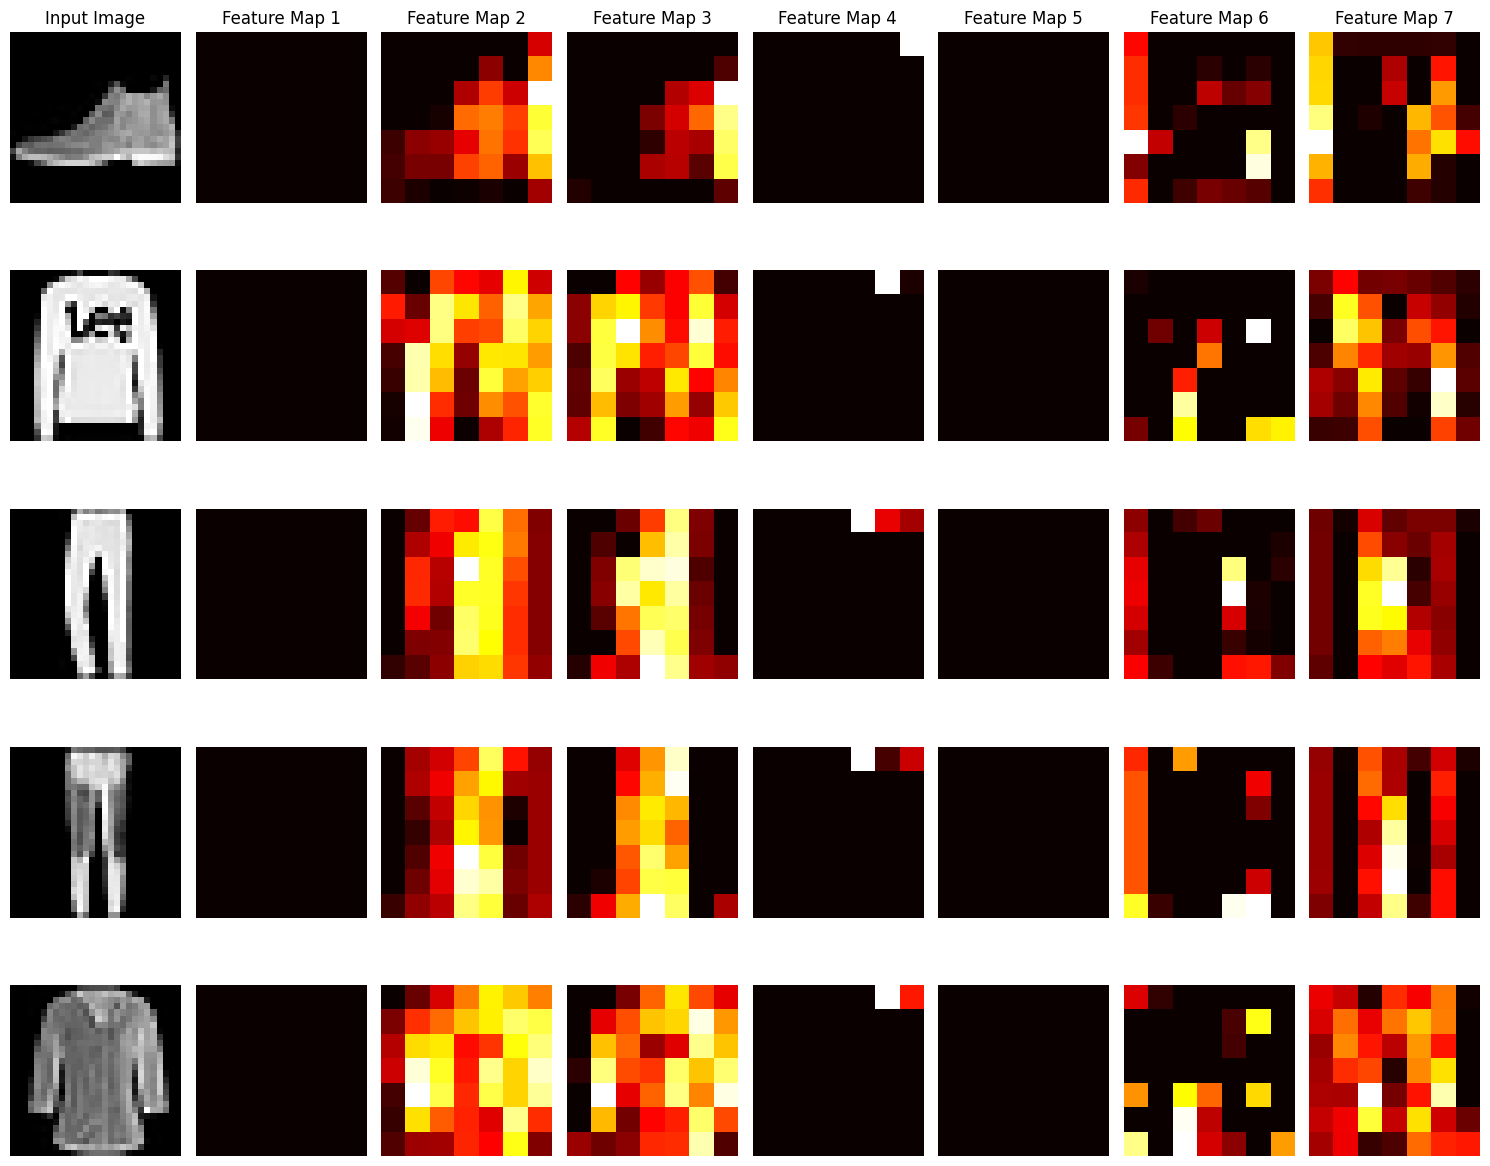

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

def visualize_features_and_inputs(model, data_loader, num_images=5, num_maps=5):
    model.eval()  # Ensure the model is in eval mode
    fig, axes = plt.subplots(num_images, num_maps + 1, figsize=(15, 2.5 * num_images))  # Rows, Columns

    for idx in range(num_images):
        # Get the next batch of images
        images, _ = next(iter(data_loader))  # Get a batch of images
        images = images.to(device)

        # Get the final output and feature maps from the model
        _, feature_maps = model(images)
        feature_maps = feature_maps.cpu().data

        # Display the input image
        input_img = torchvision.utils.make_grid(images[idx].cpu())  # Move to CPU first, then make grid
        axes[idx, 0].imshow(input_img.numpy().transpose((1, 2, 0)), cmap='gray')
        axes[idx, 0].set_title('Input Image' if idx == 0 else '')  # Title only on the first row
        axes[idx, 0].axis('off')

        # Display all feature maps on the same row
        for i in range(num_maps):
            if i < feature_maps.size(1):  # Check if the feature map index exists
                fmap = feature_maps[idx, i]  # 0 is the first image of the batch, i is the feature map index
                axes[idx, i + 1].imshow(fmap, cmap='hot')
                axes[idx, i + 1].set_title(f'Feature Map {i+1}' if idx == 0 else '')  # Title only on the first row
                axes[idx, i + 1].axis('off')
            else:
                # Clear any unused axes if there are fewer feature maps than num_maps
                axes[idx, i + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function specifying the number of images and feature maps
visualize_features_and_inputs(cnn_model, test_loader, num_images=5, num_maps=7)

This code block visualizes predictions from both the MLP and CNN models on a set of images from the FashionMNIST dataset. We place the models in evaluation mode to ensure they're not in training mode, which could affect their output due to components like dropout. We then load a batch of images and perform predictions using both models. Each image is displayed along with its true label and the predictions from both models, allowing us to visually assess and compare the performance of each model side-by-side. This side-by-side comparison is vital for understanding how each model processes and classifies the same set of images, providing insight into their respective strengths and weaknesses in image recognition tasks.

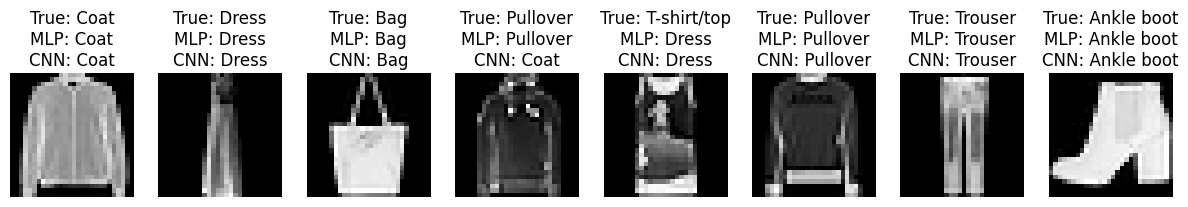

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Assuming the models (MLP and CNN) and device setup are already defined and imported

# Function to display images and labels
def imshow(img, ax, title):
    img = img / 2 + 0.5  # unnormalize if normalization was applied
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# Put models in evaluation mode
model.eval()
cnn_model.eval()

# Numer of images to show
N_samples = 8

# DataLoader setup
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=N_samples, shuffle=True)

# Fetch images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move images to device
images = images.to(device)
labels = labels.to(device)

# Get predictions from both models
with torch.no_grad():
    outputs_mlp = model(images)
    _, predicted_mlp = torch.max(outputs_mlp, 1)

    outputs_cnn,_ = cnn_model(images)
    _, predicted_cnn = torch.max(outputs_cnn, 1)

# Classes in FashionMNIST
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


# Setup matplotlib figures
fig, axes = plt.subplots(1, N_samples, figsize=(15, 5))
images = images.cpu()
labels = labels.cpu()
predicted_mlp = predicted_mlp.cpu()
predicted_cnn = predicted_cnn.cpu()

# Display each image
for i in range(N_samples):
    ax = axes[i]
    imshow(images[i], ax, f"True: {classes[labels[i]]}\nMLP: {classes[predicted_mlp[i]]}\nCNN: {classes[predicted_cnn[i]]}")

plt.show()

This code segment is set up to rigorously evaluate both the MLP and CNN models on the validation dataset from FashionMNIST. The function evaluate_model places the model in evaluation mode, processes the images from the validation set, and computes the predictions. It then compares these predictions against the true labels to calculate metrics such as accuracy, a detailed classification report, and a confusion matrix. These metrics provide a comprehensive overview of each model's performance, highlighting their effectiveness in classifying fashion items. By evaluating both models in succession, we can directly compare their predictive accuracies and understand the impact of different architectural decisions on model performance.








In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

# Function to evaluate the model on the validation set
def evaluate_model(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # If the model returns a tuple, select only the logits
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            y_preds.extend(predicted.view(-1).cpu().numpy())  # Store predictions
            y_true.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_preds)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_true, y_preds, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_preds))

    return accuracy

# Assuming `model` (MLP) and `cnn_model` are already defined and imported correctly
# Evaluate MLP model
print("\n---------------MLP MODEL---------------\n")
mlp_accuracy = evaluate_model(validation_loader, model)
# Evaluate CNN model
print("\n---------------CNN MODEL---------------\n")
cnn_accuracy = evaluate_model(validation_loader, cnn_model)


---------------MLP MODEL---------------

Accuracy: 0.8565
Classification Report:
               precision    recall  f1-score   support

           0     0.7790    0.8342    0.8057      1158
           1     0.9793    0.9660    0.9726      1176
           2     0.7488    0.7980    0.7726      1173
           3     0.8496    0.8650    0.8573      1267
           4     0.7623    0.7812    0.7716      1170
           5     0.9496    0.9244    0.9368      1203
           6     0.6941    0.5668    0.6240      1205
           7     0.9197    0.9168    0.9183      1250
           8     0.9465    0.9680    0.9571      1188
           9     0.9149    0.9413    0.9279      1210

    accuracy                         0.8565     12000
   macro avg     0.8544    0.8562    0.8544     12000
weighted avg     0.8550    0.8565    0.8549     12000

Confusion Matrix:
 [[ 966    3   25   62    2    2   82    0   16    0]
 [   0 1136   11   25    2    0    1    1    0    0]
 [  14    1  936   13  126    0  